<a href="https://colab.research.google.com/github/manmeet3/Masters_Project/blob/master/wip_colabs/tumor_anomaly/kaggle_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.groundai.com/project/ganomaly-semi-supervised-anomaly-detection-via-adversarial-training/1

https://github.com/chychen/tf2-ganomaly

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/

/content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection


In [ ]:
# %cd ganomaly_tf2
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/metrics.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/model.py
# !wget https://raw.githubusercontent.com/chychen/tf2-ganomaly/master/train.py

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
import os
import time
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ganomaly_tf2.model import GANomaly
from absl import logging
logging.set_verbosity(logging.INFO)
logging.set_stderrthreshold(logging.INFO)

from typing import Any, Callable, Optional, Tuple
from PIL import Image
from sklearn.model_selection import train_test_split

2.4.1


In [4]:
def batch_resize(imgs, size: tuple):
    img_out = np.empty((imgs.shape[0],) + size)
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

In [5]:
class Option:
    def __init__(self):
        self.anomaly = 1 # the anomaly digit
        self.shuffle_buffer_size = 10000
        self.batch_size = 8
        self.isize = 256 # input size
        self.ckpt_dir = "ckpt"
        self.nz = 100 # latent dims
        self.nc = 1 # input channels
        self.ndf = 64 # number of discriminator's filters
        self.ngf = 64 # number of generator's filters
        self.extralayers = 0
        self.niter = 15 # number of training epochs
        self.lr = 2e-4 
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5
        self.encdims = None
            
opt = Option()

In [ ]:
data_train, data_test = tf.keras.datasets.mnist.load_data()
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [15]:
def read_data(path, normal=True):
    data: Any = []
    labels = []
    
    for file_path in glob.glob(path):
        with open (file_path, 'rb') as f:
            # image needs to be a PIL image
            img = Image.open(f).convert('L')
            # image size
            # width, height = img.size
            # mode = img.mode
            # print(f"w: {width} h: {height} mode: {mode}")
            # Resize all images 176, 256, 3 -> 256, 256, 0
            dsize = (256, 256)
            resized = img.resize(dsize)
            # After resize
            # width, height = resized.size
            # mode = resized.mode
            # print(f"RESIZED: w: {width} h: {height} mode: {mode}")
            data.append(resized)
            labels.append(1 if normal else 0) 
            
    data = np.vstack(data).reshape(-1, 256, 256)
    data = data.transpose((0, 1, 2))  # convert to HWC
    return (data, labels)

In [16]:
train_image_number = 140 # Image slice from MRI scans to use for training data
#root_dir = '/content/drive/MyDrive/Masters_Project/Datasets/OASIS3/'
root = '/content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/'
normal_folder = 'no/'
tumor_folder = 'yes/'

normal_jpg_folder = os.path.join(root, normal_folder)
tumor_jpg_folder = os.path.join(root, tumor_folder)
    
print("="*5 + " Loading Data " + "="*5)
print(f"tumor_jpg_folder: {tumor_jpg_folder}")
print(f"normal_jpg_folder: {normal_jpg_folder}")

non_ad_data: Any = []
non_ad_targets = []

ad_data: Any = []
ad_targets = []

# Read data and label into a numpy array
non_ad_data, non_ad_targets = read_data(normal_jpg_folder+'**.jpg', normal=True)
ad_data, ad_targets = read_data(tumor_jpg_folder+'**.jpg', normal=False)

# shuffle the datasets and bucket them as test and train
# (non_ad_data, non_ad_targets) = shuffle_associated_arrays(non_ad_data, non_ad_targets)
# (ad_data, ad_targets) = shuffle_associated_arrays(ad_data, ad_targets)

all_data = np.concatenate((non_ad_data, ad_data), axis=0)
all_targets = non_ad_targets + ad_targets

x_train, x_test, y_train, y_test =\
  train_test_split(all_data, all_targets, test_size=0.1, random_state=42)

===== Loading Data =====
tumor_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/yes/
normal_jpg_folder: /content/drive/MyDrive/Masters_Project/Datasets/new1/kaggle_tumor_detection/no/


In [18]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

y_train = np.array(y_train, dtype=np.intc)
y_test = np.array(y_test, dtype=np.intc)

In [21]:
print(x_train.shape)
print(x_test.shape)

(153, 256, 256)
(18, 256, 256)


In [22]:
x_train = batch_resize(x_train, (256, 256))[..., None]
x_test = batch_resize(x_test, (256, 256))[..., None]
# normalization
mean = x_train.mean()
stddev = x_train.std()
x_train = (x_train-mean)/stddev
x_test = (x_test-mean)/stddev
print(x_train.shape, x_train.shape)
# define abnoraml data and normal
# training data only contains normal
x_train = x_train[y_train!=opt.anomaly]
y_train = y_train[y_train!=opt.anomaly]
y_test = (y_test==opt.anomaly).astype(np.float32)
# tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(opt.shuffle_buffer_size).batch(opt.batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(opt.batch_size, drop_remainder=False)

(153, 256, 256, 1) (153, 256, 256, 1)


In [23]:
train_dataset

<BatchDataset shapes: ((8, 256, 256, 1), (8,)), types: (tf.float64, tf.int32)>

In [24]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float64, tf.float32)>

In [25]:
ganomaly = GANomaly(opt, train_dataset, valid_dataset=None, test_dataset=test_dataset)

In [26]:
ganomaly.fit(opt.niter)

INFO:absl:epoch: 0, G_losses: 42.2330, D_losses: 3.5373, samples/sec: 3.0175


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.3704   average_precision: 0.4886 ***


INFO:absl:re-init D, cost: 0.6688 secs
INFO:absl:epoch: 1, G_losses: 43.0809, D_losses: 3.7911, samples/sec: 26.0540


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.5926   average_precision: 0.6835 ***


INFO:absl:epoch: 2, G_losses: 55.3424, D_losses: 2.2669, samples/sec: 36.9208
INFO:absl:	 Testing:   roc_auc: 0.5679   average_precision: 0.6602


INFO:absl:epoch: 3, G_losses: 138.5282, D_losses: 2.5713, samples/sec: 37.5404


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.6914   average_precision: 0.7728 ***


INFO:absl:epoch: 4, G_losses: 55.8752, D_losses: 7.7125, samples/sec: 37.5018
INFO:absl:	 Testing:   roc_auc: 0.5185   average_precision: 0.5250


INFO:absl:epoch: 5, G_losses: 40.7449, D_losses: 7.4492, samples/sec: 37.0771


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.7531   average_precision: 0.7608 ***


INFO:absl:re-init D, cost: 1.9107 secs
INFO:absl:epoch: 6, G_losses: 39.0123, D_losses: 1.8814, samples/sec: 17.6635
INFO:absl:	 Testing:   roc_auc: 0.4444   average_precision: 0.6046


INFO:absl:re-init D, cost: 0.1286 secs
INFO:absl:epoch: 7, G_losses: 36.2087, D_losses: 4.7737, samples/sec: 35.0670


Saving to: ckpt/best


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestgen/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets


INFO:tensorflow:Assets written to: ckpt/bestdisc/assets
INFO:absl:*** 	 Testing:   roc_auc: 0.7531   average_precision: 0.7608 ***


INFO:absl:epoch: 8, G_losses: 65.9988, D_losses: 7.4587, samples/sec: 36.9783
INFO:absl:	 Testing:   roc_auc: 0.3580   average_precision: 0.4428


INFO:absl:epoch: 9, G_losses: 86.4810, D_losses: 7.7125, samples/sec: 37.4776
INFO:absl:	 Testing:   roc_auc: 0.3457   average_precision: 0.4562


INFO:absl:epoch: 10, G_losses: 79.9992, D_losses: 7.7125, samples/sec: 38.0323
INFO:absl:	 Testing:   roc_auc: 0.3457   average_precision: 0.4335


INFO:absl:epoch: 11, G_losses: 55.5483, D_losses: 7.7125, samples/sec: 37.8049
INFO:absl:	 Testing:   roc_auc: 0.3457   average_precision: 0.4335


INFO:absl:epoch: 12, G_losses: 52.8530, D_losses: 7.7125, samples/sec: 36.9053
INFO:absl:	 Testing:   roc_auc: 0.4074   average_precision: 0.4502


INFO:absl:epoch: 13, G_losses: 46.7167, D_losses: 7.7125, samples/sec: 37.4187
INFO:absl:	 Testing:   roc_auc: 0.3951   average_precision: 0.4663


INFO:absl:epoch: 14, G_losses: 45.3215, D_losses: 7.7125, samples/sec: 36.5602
INFO:absl:	 Testing:   roc_auc: 0.5062   average_precision: 0.5863


Loading from: ckpt/best


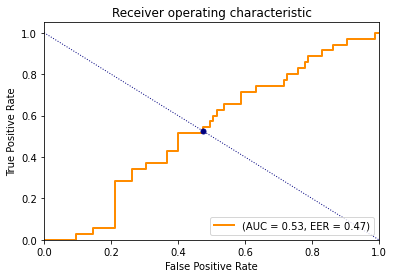

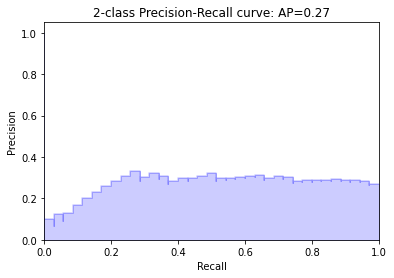

In [ ]:
ganomaly.evaluate_best(test_dataset)

In [ ]:
#!mkdir -p ./ganomaly_tf2/output

In [ ]:
%mkdir -p saved_model

In [27]:
ganomaly.save('./output/')

Saving to: ./output/


INFO:tensorflow:Assets written to: ./output/gen/assets


INFO:tensorflow:Assets written to: ./output/gen/assets


INFO:tensorflow:Assets written to: ./output/disc/assets


INFO:tensorflow:Assets written to: ./output/disc/assets


In [ ]:
# Change to be latest saved folder
D = tf.keras.models.load_model('save_model/disc')

In [ ]:
x_test[0].shape

(256, 256, 1)

In [ ]:
y_test[0]

0.0

In [ ]:
D.predict(test_dataset)

(array([[[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[1.905391e-31]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        [[[0.000000e+00]]],
 
 
        